# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install imbalanced-learn

In [2]:
!pip install scikit-learn==0.24.1

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
from workspace import active_session

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pylab import *

from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

with open('selected_columns.pkl', 'rb') as f:
    selected_columns = pickle.load(f)

# magic word for producing visualizations in notebook
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', 370)
pd.set_option('display.max_rows', 500)

### Elbow

In [22]:
def optimal_number_of_clusters(wcss):
    """
    Calculates the longest distance between the points that mark the
    sums of the intra-cluster squares for 19 clusters calculated with the function'calculate_wcss()'
    
    :params:
    wcss : list. Sum squares values
    
    :return:
    int : optimal number of clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2


def calculate_wcss(data):
    """
    Calculates the sum of the intra-cluster squares for 19 cluster quantities, starting with a minimum of 2 clusters
    
    :params:
    data : Pandas DataFrame. Dataset to fit KMeans
    
    :return:
    wcss : list. Sum squares values
    """
    wcss = []
    print("Calculating:")
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
        print(f"{n} Clusters OK!")

    return wcss

### Cluster Plot

In [27]:
def plot_clusters(model, df1,df2,label1='General Population',label2="Customers"):
    """
    This function plot the population clusters in datasets
    :params:
    model: KMeans model. Fitted model for clusters
    df1, df2: Pandas DataFrame. Dataframes to compare and plot
    label1, label2: String. Strings to show in the plot
    :return:
    None
    """

    azdias_K = list(model.predict(df1))
    for i in range(len(azdias_K)):
        azdias_K[i] += 1
    customers_K =  list(model.predict(df2))
    for i in range(len(customers_K)):
        customers_K[i] += 1

    data_label = []
    for i in range(len(df1)):
        data_label.append('General Population')
    for i in range(len(df2)):
        data_label.append('Customers')

    data_clusters = azdias_K + customers_K

    data_dict = {'Data':data_label,
                 'Cluster':data_clusters}

    df_clusters = pd.DataFrame(data_dict)
    pop_data1 = list(df_clusters[df_clusters['Data']=='General Population']['Data'].values)
    customers_data1 = list(df_clusters[df_clusters['Data']=='General Population']['Cluster'].values)
    pop_data2 = list(df_clusters[df_clusters['Data']=='Customers']['Data'].values)
    customers_data2 = list(df_clusters[df_clusters['Data']=='Customers']['Cluster'].values)


    pop_dict = dict(Counter(azdias_K))
    c_dict = dict(Counter(customers_K))
    tot_pop = len(azdias_K)
    tot_customers = len(customers_K)

    azdias_k_perc = []
    customers_k_perc = []

    for i in list(set(customers_K)):
        item = pop_dict[i]
        item = round(item / tot_pop, 2)
        azdias_k_perc.append(item)

    for i in list(set(customers_K)):
        item = c_dict[i]
        item = round(item / tot_customers, 2)
        customers_k_perc.append(item)

    plt.rcParams['figure.figsize'] = [15, 7]

    labels = list(set(customers_K))

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, azdias_k_perc, width, label=label1)
    rects2 = ax.bar(x + width/2, customers_k_perc, width, label=label2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Clusters')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    fig.savefig("Cluster.png")

# PCA Funcs

In [75]:
def pca_model(df, n_components):
    '''
    This function defines a model that takes in a dataframe and returns model fitted in a dataframe. 
    :param:
    df: Pandas DataFrame. Dataframe to be fitted
    n_components: Integer. Number of components to fit
    :return:
    pca: KMeans(). Fitted model
    '''
    pca = PCA(n_components, svd_solver='full')
    
    return pca.fit(df)

def scree_plots(df,dataname):
    '''
    This function takes in the transformed data using PCA and plots it in scree plots
    :params:
    df: PandasDataframe. PCA transformed data
    dataname: String. String used in the tittle
    :return None:
    
    '''
    plt.rcParams["figure.figsize"] = (20,20)
    subplot(2,1,1)

    plt.plot(np.cumsum(df.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs Number of Components ' + dataname)
    plt.grid(b=True)


    plot = tight_layout()
    plot = plt.show()
    savefig('PCA_feat.png',format='png',dpi=200)
    
def display_interesting_features(df, pca, dimensions,show=5):
    '''
    This function displays interesting features of the selected dimension
    :params:
    df: PandasDataFrame. Base Data
    pca: PCA model
    dimensions: Integer. Number of dimensions
    show: Integer. Number of features to show
    '''
    
    features = df.columns
    components = pca.components_
    feature_weights = dict(zip(features, components[dimensions]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    list_feat = []
    
    print('Lowest: ')
    for feature, weight, in sorted_weights[:show]:
        print('\t{:20} {:.3f}'.format(feature, weight))
        list_feat.append(feature)
    print('Highest: ')
    for feature, weight in sorted_weights[show*-1:]:
        print('\t{:20} {:.3f}'.format(feature, weight))
        list_feat.append(feature)
        
    return list_feat
        
    

### Load Attributes

In [8]:
from functions import *
attributes, attributes_info = read_and_standardize_attributes()

# Customer Segmentation Report

In [9]:
%%time
with open('azdias_clean.pkl', 'rb') as f:
        azdias_clean= pickle.load(f)
        
with open('customers_clean.pkl', 'rb') as f:
    customers_clean = pickle.load(f)

CPU times: user 624 ms, sys: 2.64 s, total: 3.27 s
Wall time: 43.8 s


In [10]:
with open('azdias_scaler.pkl', 'rb') as f:
    azdias_scaler = pickle.load(f)
    
azdias_scaled = azdias_scaler.transform(azdias_clean.copy())
customers_scaled = azdias_scaler.transform(customers_clean.copy())

Since in the preprocessing notebook it was noticed that 62 componentes of PCA explained 80% of variance. I will run PCA with 62 components

In [11]:
%%time
pca_62 = PCA(62)
pca_62.fit(azdias_scaled)

with open('pca_62.pkl', 'wb') as f:
    pickle.dump(pca_62,f)

In [11]:
#with open('pca_62.pkl', 'rb') as f:
    #pca_62 = pickle.load(f)

In [55]:
%%time
azdias_pca = pca_62.transform(azdias_scaled)
customers_pca = pca_62.transform(customers_scaled)

CPU times: user 3.71 s, sys: 23.8 s, total: 27.5 s
Wall time: 3min 46s


In [13]:
print(azdias_pca.shape)
print(customers_pca.shape)

(891221, 62)
(191652, 62)


In [14]:
%%time
# Calculate the sum of the intra-cluster squares for 19 cluster quantities, starting with a minimum of 2 clusters
with active_session():
    wcss = calculate_wcss(azdias_pca)

Calculating:
2 Clusters OK!
3 Clusters OK!
4 Clusters OK!
5 Clusters OK!
6 Clusters OK!
7 Clusters OK!
8 Clusters OK!
9 Clusters OK!
10 Clusters OK!
11 Clusters OK!
12 Clusters OK!
13 Clusters OK!
14 Clusters OK!
15 Clusters OK!
16 Clusters OK!
17 Clusters OK!
18 Clusters OK!
19 Clusters OK!
20 Clusters OK!
CPU times: user 36min 33s, sys: 11.6 s, total: 36min 44s
Wall time: 36min 53s


In [15]:
%%time
with active_session():
    optimal_clusters = optimal_number_of_clusters(wcss)

CPU times: user 5.16 ms, sys: 0 ns, total: 5.16 ms
Wall time: 13.4 ms


Optimal number of Clusters: 8


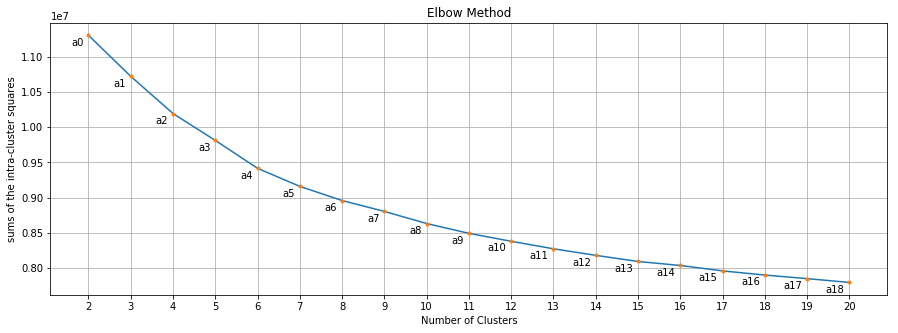

In [20]:
x1, x2 = 2, 20
x_range = range(x1,x2+1)

print(f"Optimal number of Clusters: {optimal_clusters}")
plt.figure(figsize=(15,5))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('sums of the intra-cluster squares')
plt.grid()
plt.xticks(x_range)
plt.plot(x_range, wcss) # orange points
plt.plot(x_range, wcss, '.') # blue line
for x,y in zip(x_range,wcss): # labeling points
    label = "a{}".format(x-2)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(-5,-10),
                 ha='right')
plt.savefig('elbow_plot.png')

In [21]:
%%time
# Fit K_Mean Model with optimal clusters
kmeans_optimal_model = KMeans(n_clusters=optimal_clusters)
kmeans_optimal_model.fit(azdias_pca)

with open('kmeans_optimal_model.pkl', 'wb') as f:
    pickle.dump(kmeans_optimal_model,f)

CPU times: user 1min 43s, sys: 633 ms, total: 1min 44s
Wall time: 1min 44s


## Customers Clusters

CPU times: user 8.74 s, sys: 91.3 ms, total: 8.83 s
Wall time: 8.95 s


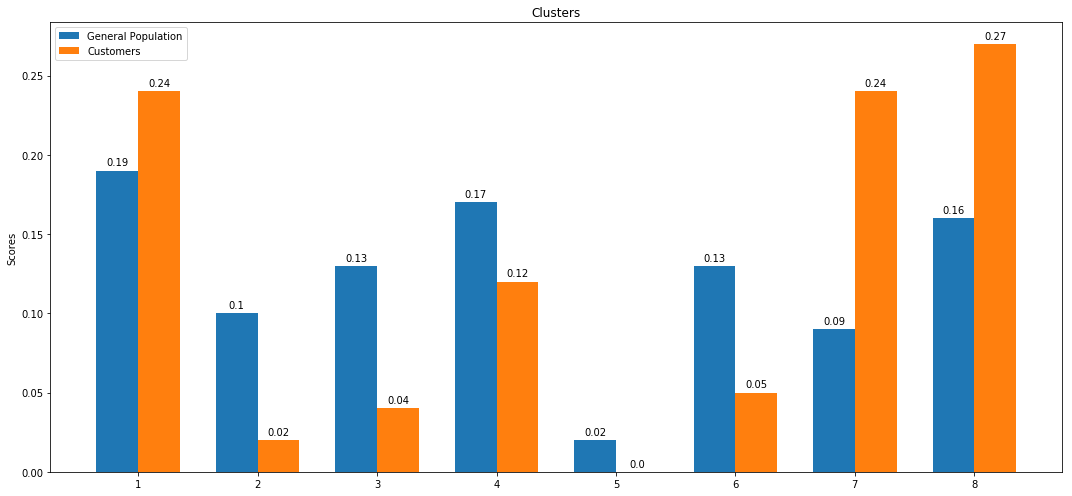

In [28]:
%%time
plot_clusters(kmeans_optimal_model, azdias_pca,customers_pca)

In [35]:
with open('final_columns.pkl', 'rb') as f:
    final_columns = pickle.load(f)

azdias_scaled = pd.DataFrame(azdias_scaled, columns=final_columns)
customers_scaled = pd.DataFrame(customers_scaled, columns=final_columns)

In [38]:
#azdias_pca = pca_model(azdias_scaled, len(azdias_scaled.columns))
#with open('pca_explain_features_final.pkl', 'wb') as f:
    #pickle.dump(azdias_pca,f)
    
with open('pca_explain_features_final.pkl', 'rb') as f:
    pca_feat_exp = pickle.load(f)

In [56]:
#Predicting Clusters
azdias_scaled['Cluster'] = kmeans_optimal_model.predict(azdias_pca)
customers_scaled['Cluster'] = kmeans_optimal_model.predict(customers_pca)

In [66]:
attributes[attributes['Attribute']=='D19_VERSAND_ONLINE_QUOTE_12']

,Attribute,Description,Value,Meaning
590,D19_VERSAND_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months


## Looking for interesting features

In [76]:
interesting_features = display_interesting_features(azdias_scaled, pca_feat_exp, 0,show=10)

Lowest: 
	D19_KONSUMTYP        -0.200
	D19_GESAMT_DATUM     -0.184
	D19_GESAMT_ONLINE_DATUM -0.170
	D19_VERSAND_DATUM    -0.168
	D19_VERSAND_ONLINE_DATUM -0.160
	PLZ8_ANTG3           -0.156
	PLZ8_BAUMAX          -0.147
	EWDICHTE             -0.144
	PLZ8_ANTG4           -0.143
	FINANZ_HAUSBAUER     -0.143
Highest: 
	income_category      0.140
	D19_GESAMT_ANZ_24    0.144
	GREEN_AVANTGARDE     0.145
	positioning          0.145
	KBA05_GBZ            0.147
	MOBI_REGIO           0.154
	KBA05_ANTG1          0.176
	D19_VERSAND_ONLINE_QUOTE_12 0.183
	D19_GESAMT_ONLINE_QUOTE_12 0.193
	wealth               0.197


Lets take a look in some details about the clusters

In [127]:
%%time
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers_extra_columns = customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP']].copy()
customers = None
customers_scaled['ONLINE_PURCHASE'] = customers_extra_columns['ONLINE_PURCHASE'].values

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 8.68 s, sys: 576 ms, total: 9.26 s
Wall time: 9.31 s


Since the 3 clusters that overrepresented if grouped represents approximately 75% i'll used them grouped to understand it's characteristics.

In [128]:
customers_scaled['majorgroup'] = 0
customers_scaled.loc[((customers_scaled['Cluster']==0) | (customers_scaled['Cluster']==3) | (customers_scaled['Cluster']==7)), 'majorgroup'] = 1

Online Purchase Diff

In [146]:
print(f"Overrepresented Clusters Online Purchase percentage is: {round((customers_scaled[customers_scaled['majorgroup']==1]['ONLINE_PURCHASE'].sum() / len(customers_clusters)) * 100, 2)}%")
print(f"Other Clusters Online Purchase percentage is: {round(customers_scaled[customers_scaled['majorgroup']==0]['ONLINE_PURCHASE'].sum() / len(non_customers_clusters) * 100, 2)}%")

Overrepresented Clusters Online Purchase percentage is: 8.57%
Other Clusters Online Purchase percentage is: 9.81%


In [194]:
def plot_mean_feat(df,feat):
    try:
        description = attributes[attributes['Attribute']==feat]['Description'].values[0]
    except:
        description = "Feature Created by the author"
    title = feat.title().replace('_',' ')
    full_title = f"{title}: {description}"
    df.groupby('majorgroup')[feat].mean().plot(kind='bar',title=feat.title().replace('_',' '))

## Comparing Features

In [165]:
interesting_features

['D19_KONSUMTYP',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'PLZ8_ANTG3',
 'PLZ8_BAUMAX',
 'EWDICHTE',
 'PLZ8_ANTG4',
 'FINANZ_HAUSBAUER',
 'income_category',
 'D19_GESAMT_ANZ_24',
 'GREEN_AVANTGARDE',
 'positioning',
 'KBA05_GBZ',
 'MOBI_REGIO',
 'KBA05_ANTG1',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'wealth']

##### Label 1: Overrepresented Clusters in customers data grouped
##### Label 2: Other Clusters Grouped

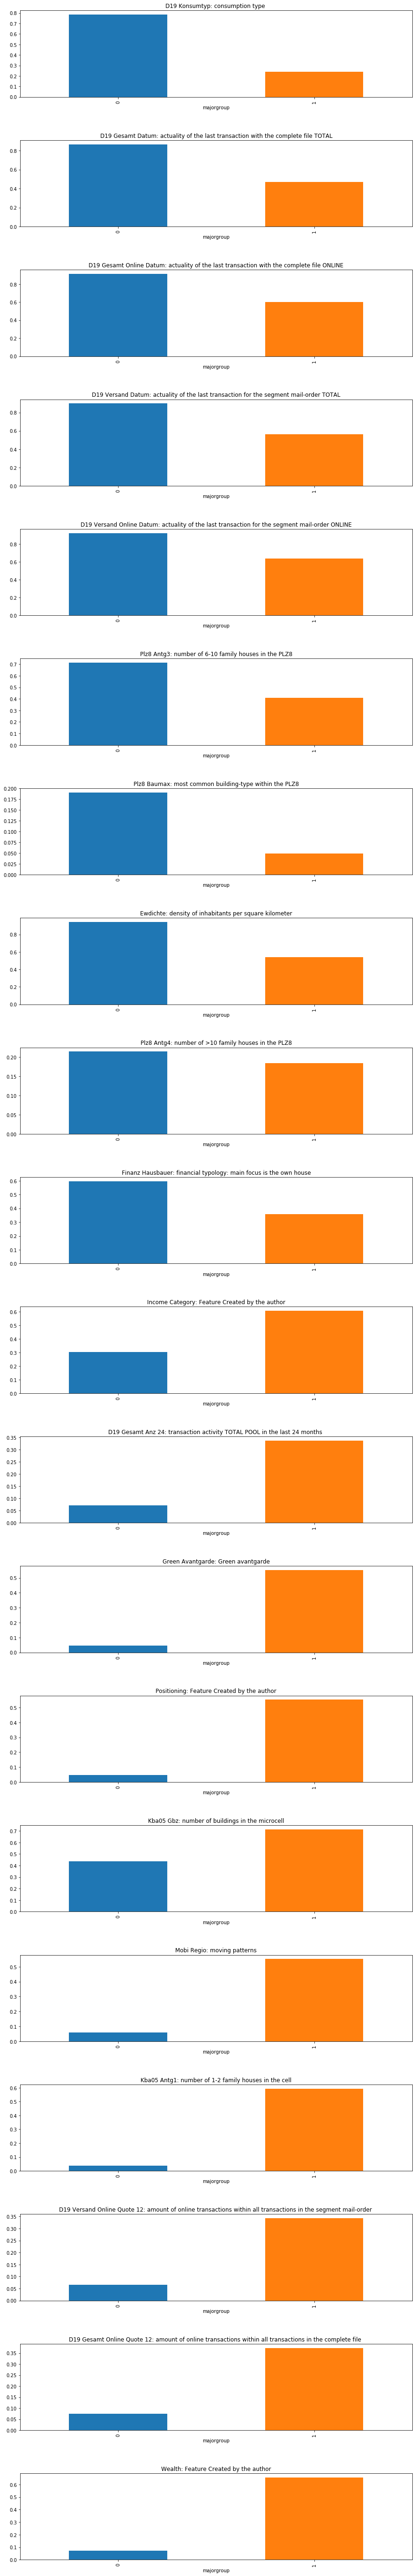

In [182]:
fig, axes = plt.subplots(nrows=len(interesting_features), ncols=1,figsize=(15, 100))
fig.subplots_adjust(hspace = .5, wspace=.001)

for j, feat in enumerate(interesting_features):
    try:
        description = attributes[attributes['Attribute']==feat]['Description'].values[0]
    except:
        description = "Feature Created by the author"
    title = feat.title().replace('_',' ')
    full_title = f"{title}: {description}"
    customers_scaled.groupby('majorgroup')[feat].mean().plot(kind='bar',title=full_title ,ax=axes.flat[j])

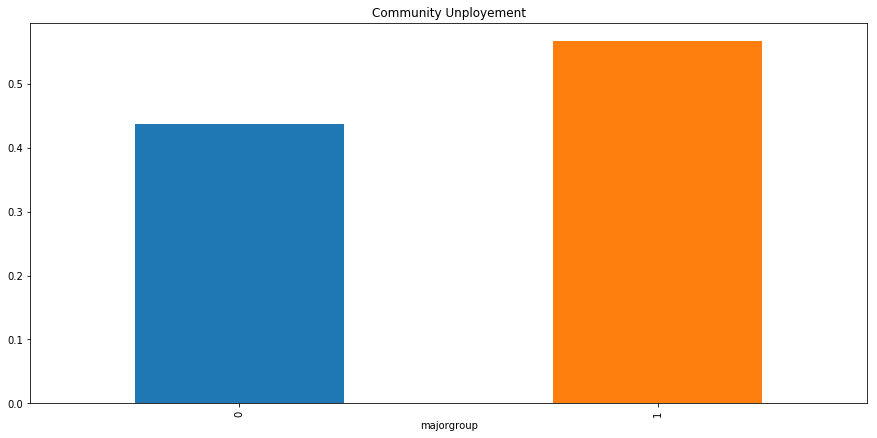

In [199]:
plot_mean_feat(customers_scaled, 'community_unployement')

In the feature 'Community Unployement' it has to take into consideration that the higher the value e lowest the unployement in the neighborhood community

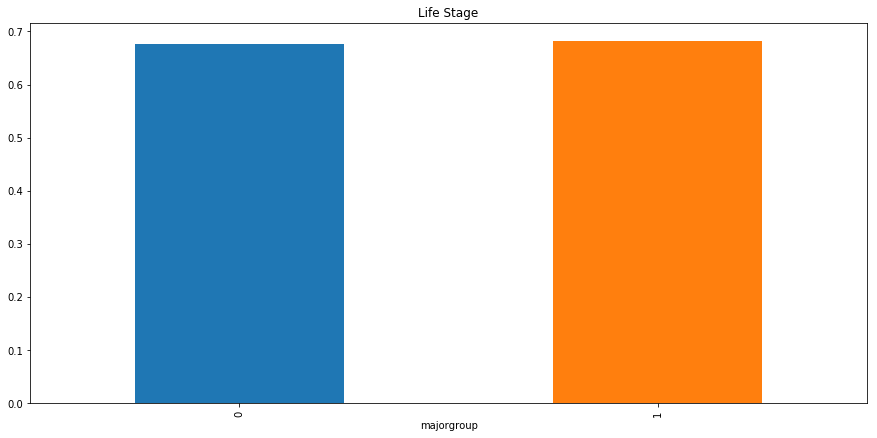

In [198]:
plot_mean_feat(customers_scaled, 'life_stage')

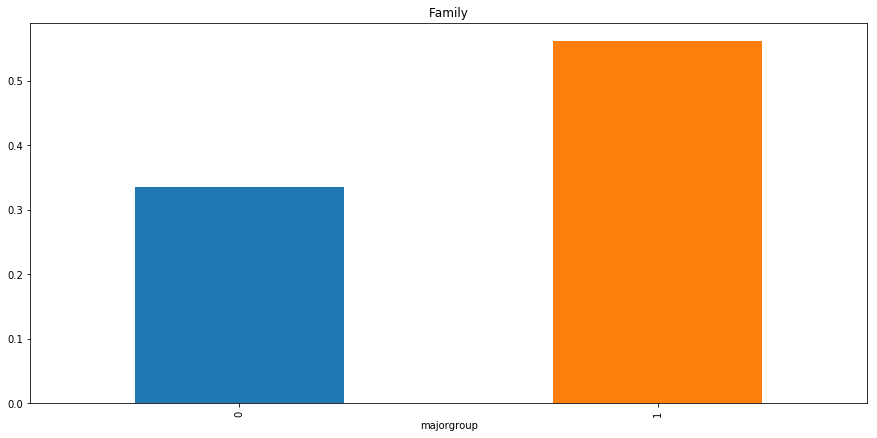

In [200]:
plot_mean_feat(customers_scaled, 'family')

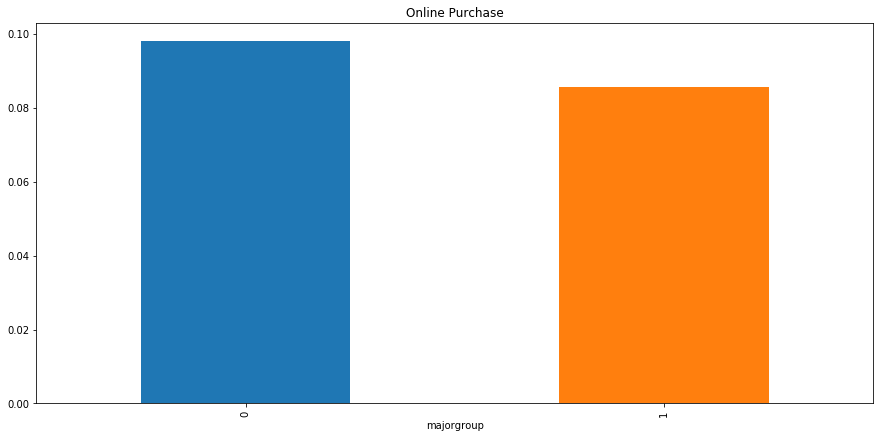

In [201]:
plot_mean_feat(customers_scaled, 'ONLINE_PURCHASE')

In [202]:
attributes[attributes['Attribute'] == 'GREEN_AVANTGARDE']

,Attribute,Description,Value,Meaning
732,GREEN_AVANTGARDE,Green avantgarde,0,doesn't belong to the green avantgarde
733,GREEN_AVANTGARDE,the environmental sustainability is the domina...,1,belongs to the green avantgarde


## Conclusion

Looking into data it can be said that the group of potencial customers:
- Individuals with Higher income and wealth. 
- Individuals which is  more avantgard than mainstream, like green avantgarde ( sustainability)
- Live in areas with lower density of inhabitants and lower unemployement.
- Has higher mobility
- Mid-ager with family individuals

If the company were willing to launch a marketing campaign, it would be recommended to target these groups of people.

it is hard to describe some data clusters. If I had to do it again i would probably drop some features without feature meaning or make dummy variables of them and them come with more knowledge avoiding some features that is difficult to interpret.